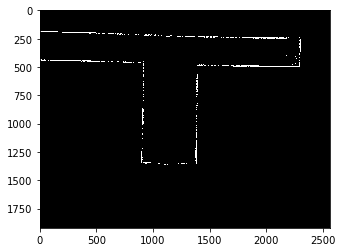

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('test1.jpg')   # you can read in images with opencv
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1 = np.asarray([170,70,50])   # white!
hsv_color2 = np.asarray([180,255,255])   # yellow! note the order

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

# Creating kernel
# kernel1 = np.ones((2, 2), np.uint8)
#kernel2 = np.ones((2, 2), np.uint8)
  
# img_erosion = cv2.erode(mask, kernel1, iterations=1)
#mask = cv2.dilate(mask, kernel2, iterations=5)
# # Using cv2.erode() method 
# mask = cv2.erode(mask, kernel) 

plt.imshow(mask, cmap='gray')   # this colormap will display in black / white
plt.show()

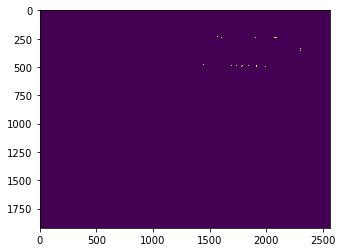

In [24]:
cnt = sorted(cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
m = np.zeros(mask.shape[0:2], dtype='uint8')
cv2.drawContours(m, cnt, -1, ( 255), -1)
plt.imshow(m)

In [10]:
b = np.where(mask==255)
b = list(zip(b[1],b[0]))
print(b)

[(72, 184), (73, 184), (74, 184), (75, 184), (76, 184), (77, 184), (78, 184), (44, 185), (45, 185), (46, 185), (47, 185), (48, 185), (49, 185), (50, 185), (66, 185), (67, 185), (68, 185), (69, 185), (70, 185), (71, 185), (72, 185), (73, 185), (74, 185), (75, 185), (76, 185), (77, 185), (78, 185), (79, 185), (0, 186), (1, 186), (2, 186), (3, 186), (4, 186), (5, 186), (6, 186), (7, 186), (8, 186), (9, 186), (10, 186), (11, 186), (12, 186), (13, 186), (14, 186), (15, 186), (16, 186), (17, 186), (18, 186), (19, 186), (20, 186), (21, 186), (22, 186), (23, 186), (24, 186), (34, 186), (35, 186), (36, 186), (37, 186), (38, 186), (39, 186), (40, 186), (41, 186), (42, 186), (43, 186), (44, 186), (45, 186), (46, 186), (47, 186), (48, 186), (49, 186), (50, 186), (51, 186), (52, 186), (56, 186), (57, 186), (58, 186), (59, 186), (60, 186), (61, 186), (62, 186), (63, 186), (64, 186), (65, 186), (66, 186), (67, 186), (68, 186), (69, 186), (70, 186), (71, 186), (72, 186), (73, 186), (74, 186), (75, 186

KeyboardInterrupt: 

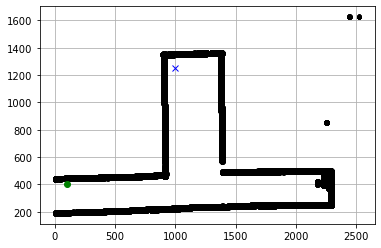

In [12]:

# import numpy as np
# import matplotlib.pyplot as plt

import sys
sys.path.append("../../PathPlanning/CubicSpline/")

try:
    import cubic_spline_planner
except:
    raise


show_animation = True
use_beam_search = True
use_iterative_deepening = False
use_dynamic_weighting = False
use_theta_star = False
use_jump_point = False

beam_capacity = 30
max_theta = 5
only_corners = False
max_corner = 5
w, epsilon, upper_bound_depth = 1, 4, 500

k = 0.5  # control gain
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time difference
L = 15  # [cm] Wheel base of vehicle
max_steer = np.radians(90.0)  # [rad] max steering angle

def draw_horizontal_line(start_x, start_y, length, o_x, o_y, o_dict):
    for i in range(start_x, start_x + length):
        for j in range(start_y, start_y + 2):
            o_x.append(i)
            o_y.append(j)
            o_dict[(i, j)] = True


def draw_vertical_line(start_x, start_y, length, o_x, o_y, o_dict):
    for i in range(start_x, start_x + 2):
        for j in range(start_y, start_y + length):
            o_x.append(i)
            o_y.append(j)
            o_dict[(i, j)] = True


def in_line_of_sight(obs_grid, x1, y1, x2, y2):
    t = 0
    while t <= 0.5:
        xt = (1 - t) * x1 + t * x2
        yt = (1 - t) * y1 + t * y2
        if obs_grid[(int(xt), int(yt))]:
            return False, None
        xt = (1 - t) * x2 + t * x1
        yt = (1 - t) * y2 + t * y1
        if obs_grid[(int(xt), int(yt))]:
            return False, None
        t += 0.001
    dist = np.linalg.norm(np.array([x1, y1] - np.array([x2, y2])))
    return True, dist


def key_points(o_dict):
    offsets1 = [(2, 0), (0, 2), (-2, 0), (2, 0)]
    offsets2 = [(2, 2), (-2, 2), (-2, -2), (2, -2)]
    offsets3 = [(0, 2), (-2, 0), (0, -2), (0, -2)]
    c_list = []
    for grid_point, obs_status in o_dict.items():
        if obs_status:
            continue
        empty_space = True
        x, y = grid_point
        for i in [-2, 0, 2]:
            for j in [-2, 0, 2]:
                if (x + i, y + j) not in o_dict.keys():
                    continue
                if o_dict[(x + i, y + j)]:
                    empty_space = False
                    break
        if empty_space:
            continue
        for offset1, offset2, offset3 in zip(offsets1, offsets2, offsets3):
            i1, j1 = offset1
            i2, j2 = offset2
            i3, j3 = offset3
            if ((x + i1, y + j1) not in o_dict.keys()) or \
                    ((x + i2, y + j2) not in o_dict.keys()) or \
                    ((x + i3, y + j3) not in o_dict.keys()):
                continue
            obs_count = 0
            if o_dict[(x + i1, y + j1)]:
                obs_count += 1
            if o_dict[(x + i2, y + j2)]:
                obs_count += 1
            if o_dict[(x + i3, y + j3)]:
                obs_count += 1
            if obs_count == 3 or obs_count == 1:
                c_list.append((x, y))
                if show_animation:
                    plt.plot(x, y, ".y")
                    #print(x,y)
                break
    if only_corners:
        return c_list

    e_list = []
    for corner in c_list:
        x1, y1 = corner
        for other_corner in c_list:
            x2, y2 = other_corner
            if x1 == x2 and y1 == y2:
                continue
            reachable, _ = in_line_of_sight(o_dict, x1, y1, x2, y2)
            if not reachable:
                continue
            x_m, y_m = int((x1 + x2) / 2), int((y1 + y2) / 2)
            e_list.append((x_m, y_m))
            if show_animation:
                plt.plot(x_m, y_m, ".y")
                #print(x_m,y_m)
    return c_list + e_list


class SearchAlgo:
    def __init__(self, obs_grid, goal_x, goal_y, start_x, start_y,
                 limit_x, limit_y, corner_list=None):
        self.start_pt = [start_x, start_y]
        self.goal_pt = [goal_x, goal_y]
        self.obs_grid = obs_grid
        g_cost, h_cost = 0, self.get_hval(start_x, start_y, goal_x, goal_y)
        f_cost = g_cost + h_cost
        self.all_nodes, self.open_set = {}, []
        self.closed_set = []

        if use_jump_point:
            for corner in corner_list:
                i, j = corner
                h_c = self.get_hval(i, j, goal_x, goal_y)
                self.all_nodes[(i, j)] = {'pos': [i, j], 'pred': None,
                                          'gcost': np.inf, 'hcost': h_c,
                                          'fcost': np.inf,
                                          'open': True, 'in_open_list': False}
            self.all_nodes[tuple(self.goal_pt)] = \
                {'pos': self.goal_pt, 'pred': None,
                 'gcost': np.inf, 'hcost': 0, 'fcost': np.inf,
                 'open': True, 'in_open_list': True}
        else:
            for i in range(limit_x):
                for j in range(limit_y):
                    h_c = self.get_hval(i, j, goal_x, goal_y)
                    self.all_nodes[(i, j)] = {'pos': [i, j], 'pred': None,
                                              'gcost': np.inf, 'hcost': h_c,
                                              'fcost': np.inf,
                                              'open': True,
                                              'in_open_list': False}
        self.all_nodes[tuple(self.start_pt)] = \
            {'pos': self.start_pt, 'pred': None,
             'gcost': g_cost, 'hcost': h_cost, 'fcost': f_cost,
             'open': True, 'in_open_list': True}
        self.open_set.append(self.all_nodes[tuple(self.start_pt)])

    @staticmethod
    def get_hval(x1, y1, x2, y2):
        x, y = x1, y1
        val = 0
        while x != x2 or y != y2:
            if x != x2 and y != y2:
                val += 14
            else:
                val += 10
            x, y = x + np.sign(x2 - x), y + np.sign(y2 - y)
        return val

    def get_farthest_point(self, x, y, i, j):
        i_temp, j_temp = i, j
        counter = 1
        got_goal = False
        while not self.obs_grid[(x + i_temp, y + j_temp)] and \
                counter < max_theta:
            i_temp += i
            j_temp += j
            counter += 1
            if [x + i_temp, y + j_temp] == self.goal_pt:
                got_goal = True
                break
            if (x + i_temp, y + j_temp) not in self.obs_grid.keys():
                break
        return i_temp - 2*i, j_temp - 2*j, counter, got_goal

    def jump_point(self):
        """Jump point: Instead of exploring all empty spaces of the
        map, just explore the corners."""

        goal_found = False
        while len(self.open_set) > 0:
            self.open_set = sorted(self.open_set, key=lambda x: x['fcost'])
            lowest_f = self.open_set[0]['fcost']
            lowest_h = self.open_set[0]['hcost']
            lowest_g = self.open_set[0]['gcost']
            p = 0
            for p_n in self.open_set[1:]:
                if p_n['fcost'] == lowest_f and \
                        p_n['gcost'] < lowest_g:
                    lowest_g = p_n['gcost']
                    p += 1
                elif p_n['fcost'] == lowest_f and \
                        p_n['gcost'] == lowest_g and \
                        p_n['hcost'] < lowest_h:
                    lowest_h = p_n['hcost']
                    p += 1
                else:
                    break
            current_node = self.all_nodes[tuple(self.open_set[p]['pos'])]
            x1, y1 = current_node['pos']

            for cand_pt, cand_node in self.all_nodes.items():
                x2, y2 = cand_pt
                if x1 == x2 and y1 == y2:
                    continue
                if np.linalg.norm(np.array([x1, y1] -
                                           np.array([x2, y2]))) > max_corner:
                    continue
                reachable, offset = in_line_of_sight(self.obs_grid, x1,
                                                     y1, x2, y2)
                if not reachable:
                    continue

                if list(cand_pt) == self.goal_pt:
                    current_node['open'] = False
                    self.all_nodes[tuple(cand_pt)]['pred'] = \
                        current_node['pos']
                    goal_found = True
                    break

                g_cost = offset + current_node['gcost']
                h_cost = self.all_nodes[cand_pt]['hcost']
                f_cost = g_cost + h_cost
                cand_pt = tuple(cand_pt)
                if f_cost < self.all_nodes[cand_pt]['fcost']:
                    self.all_nodes[cand_pt]['pred'] = current_node['pos']
                    self.all_nodes[cand_pt]['gcost'] = g_cost
                    self.all_nodes[cand_pt]['fcost'] = f_cost
                    if not self.all_nodes[cand_pt]['in_open_list']:
                        self.open_set.append(self.all_nodes[cand_pt])
                        self.all_nodes[cand_pt]['in_open_list'] = True
                    if show_animation:
                        plt.plot(cand_pt[0], cand_pt[1], "r*")

                if goal_found:
                    break
            if show_animation:
                plt.pause(0.001)
            if goal_found:
                current_node = self.all_nodes[tuple(self.goal_pt)]
            while goal_found:
                if current_node['pred'] is None:
                    break
                x = [current_node['pos'][0], current_node['pred'][0]]
                y = [current_node['pos'][1], current_node['pred'][1]]
                current_node = self.all_nodes[tuple(current_node['pred'])]
                if show_animation:
                    plt.plot(x, y, "b")
                    #print(x,y)
                    plt.pause(0.001)
            if goal_found:
                break

            current_node['open'] = False
            current_node['in_open_list'] = False
            if show_animation:
                plt.plot(current_node['pos'][0], current_node['pos'][1], "g*")
            del self.open_set[p]
            current_node['fcost'], current_node['hcost'] = np.inf, np.inf
        if show_animation:
            plt.title('Jump Point')
            plt.show()

    def a_star(self):
        """Beam search: Maintain an open list of just 30 nodes.
        If more than 30 nodes, then get rid of nodes with high
        f values.
        Iterative deepening: At every iteration, get a cut-off
        value for the f cost. This cut-off is minimum of the f
        value of all nodes whose f value is higher than the
        current cut-off value. Nodes with f value higher than
        the current cut off value are not put in the open set.
        Dynamic weighting: Multiply heuristic with the following:
        (1 + epsilon - (epsilon*d)/N) where d is the current
        iteration of loop and N is upper bound on number of
        iterations.
        Theta star: Same as A star but you don't need to move
        one neighbor at a time. In fact, you can look for the
        next node as far out as you can as long as there is a
        clear line of sight from your current node to that node."""
        if show_animation:
            if use_beam_search:
                plt.title('A* with beam search')
            elif use_iterative_deepening:
                plt.title('A* with iterative deepening')
            elif use_dynamic_weighting:
                plt.title('A* with dynamic weighting')
            elif use_theta_star:
                plt.title('Theta*')
            else:
                plt.title('A*')

        goal_found = False
        curr_f_thresh = np.inf
        depth = 0
        no_valid_f = False
        w = None
        while len(self.open_set) > 0:
            self.open_set = sorted(self.open_set, key=lambda x: x['fcost'])
            lowest_f = self.open_set[0]['fcost']
            lowest_h = self.open_set[0]['hcost']
            lowest_g = self.open_set[0]['gcost']
            p = 0
            for p_n in self.open_set[1:]:
                if p_n['fcost'] == lowest_f and \
                        p_n['gcost'] < lowest_g:
                    lowest_g = p_n['gcost']
                    p += 1
                elif p_n['fcost'] == lowest_f and \
                        p_n['gcost'] == lowest_g and \
                        p_n['hcost'] < lowest_h:
                    lowest_h = p_n['hcost']
                    p += 1
                else:
                    break
            current_node = self.all_nodes[tuple(self.open_set[p]['pos'])]

            while len(self.open_set) > beam_capacity and use_beam_search:
                del self.open_set[-1]

            f_cost_list = []
            if use_dynamic_weighting:
                w = (1 + epsilon - epsilon*depth/upper_bound_depth)
            for i in range(-2, 3):
                for j in range(-2, 3):
                    x, y = current_node['pos']
                    if (i == 0 and j == 0) or \
                            ((x + i, y + j) not in self.obs_grid.keys()):
                        continue
                    if (i, j) in [(2, 0), (0, 2), (-2, 0), (0, -2)]:
                        offset = 10
                    else:
                        offset = 14
                    if use_theta_star:
                        new_i, new_j, counter, goal_found = \
                            self.get_farthest_point(x, y, i, j)
                        offset = offset * counter
                        cand_pt = [current_node['pos'][0] + new_i,
                                   current_node['pos'][1] + new_j]
                    else:
                        cand_pt = [current_node['pos'][0] + i,
                                   current_node['pos'][1] + j]

                    if use_theta_star and goal_found:
                        current_node['open'] = False
                        cand_pt = self.goal_pt
                        self.all_nodes[tuple(cand_pt)]['pred'] = \
                            current_node['pos']
                        break

                    if cand_pt == self.goal_pt:
                        current_node['open'] = False
                        self.all_nodes[tuple(cand_pt)]['pred'] = \
                            current_node['pos']
                        goal_found = True
                        break

                    cand_pt = tuple(cand_pt)
                    no_valid_f = self.update_node_cost(cand_pt, curr_f_thresh,
                                                       current_node,
                                                       f_cost_list, no_valid_f,
                                                       offset, w)
                if goal_found:
                    break
            if show_animation:
                plt.pause(0.001)
            if goal_found:
                current_node = self.all_nodes[tuple(self.goal_pt)]
            while goal_found:
                if current_node['pred'] is None:
                    break
                if use_theta_star or use_jump_point:
                    x, y = [current_node['pos'][0], current_node['pred'][0]], \
                             [current_node['pos'][1], current_node['pred'][1]]
                    if show_animation:
                        plt.plot(x, y, "b")
                else:
                    if show_animation:
                        plt.plot(current_node['pred'][0],
                                 current_node['pred'][1], "b*")
                    #print(current_node['pred'])
                    self.closed_set.append(current_node['pred'])
                current_node = self.all_nodes[tuple(current_node['pred'])]
            #print(self.closed_set)
            if goal_found:
                break

            if use_iterative_deepening and f_cost_list:
                curr_f_thresh = min(f_cost_list)
            if use_iterative_deepening and not f_cost_list:
                curr_f_thresh = np.inf
            if use_iterative_deepening and not f_cost_list and no_valid_f:
                current_node['fcost'], current_node['hcost'] = np.inf, np.inf
                continue

            current_node['open'] = False
            current_node['in_open_list'] = False
            if show_animation:
                plt.plot(current_node['pos'][0], current_node['pos'][1], "g*")
            del self.open_set[p]
            current_node['fcost'], current_node['hcost'] = np.inf, np.inf
            depth += 1
        if show_animation:
            plt.show()

    def update_node_cost(self, cand_pt, curr_f_thresh, current_node,
                         f_cost_list, no_valid_f, offset, w):
        if not self.obs_grid[tuple(cand_pt)] and \
                self.all_nodes[cand_pt]['open']:
            g_cost = offset + current_node['gcost']
            h_cost = self.all_nodes[cand_pt]['hcost']
            if use_dynamic_weighting:
                h_cost = h_cost * w
            f_cost = g_cost + h_cost
            if f_cost < self.all_nodes[cand_pt]['fcost'] and \
                    f_cost <= curr_f_thresh:
                f_cost_list.append(f_cost)
                self.all_nodes[cand_pt]['pred'] = \
                    current_node['pos']
                self.all_nodes[cand_pt]['gcost'] = g_cost
                self.all_nodes[cand_pt]['fcost'] = f_cost
                if not self.all_nodes[cand_pt]['in_open_list']:
                    self.open_set.append(self.all_nodes[cand_pt])
                    self.all_nodes[cand_pt]['in_open_list'] = True
                if show_animation:
                    plt.plot(cand_pt[0], cand_pt[1], "r*")
                    #print(cand_pt)
            if curr_f_thresh < f_cost < \
                    self.all_nodes[cand_pt]['fcost']:
                no_valid_f = True
        return no_valid_f
    
class State(object):
    """
    Class representing the state of a vehicle.
    :param x: (float) x-coordinate
    :param y: (float) y-coordinate
    :param yaw: (float) yaw angle
    :param v: (float) speed
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.
        Stanley Control uses bicycle model.
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        delta = np.clip(delta, -max_steer, max_steer)

        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / L * np.tan(delta) * dt
        self.yaw = normalize_angle(self.yaw)
        self.v += acceleration * dt


def pid_control(target, current):
    """
    Proportional control for the speed.
    :param target: (float)
    :param current: (float)
    :return: (float)
    """
    return Kp * (target - current)


def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.
    :param state: (State object)
    :param cx: ([float])
    :param cy: ([float])
    :param cyaw: ([float])
    :param last_target_idx: (int)
    :return: (float, int)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy)

    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    # theta_e corrects the heading error
    theta_e = normalize_angle(cyaw[current_target_idx] - state.yaw)
    # theta_d corrects the cross track error
    theta_d = np.arctan2(k * error_front_axle, state.v)
    # Steering control
    delta = theta_e + theta_d

    return delta, current_target_idx


def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi].
    :param angle: (float)
    :return: (float) Angle in radian in [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle


def calc_target_index(state, cx, cy):
    """
    Compute index in the trajectory list of the target.
    :param state: (State object)
    :param cx: [float]
    :param cy: [float]
    :return: (int, float)
    """
    # Calc front axle position
    fx = state.x + L * np.cos(state.yaw)
    fy = state.y + L * np.sin(state.yaw)

    # Search nearest point index
    dx = [fx - icx for icx in cx]
    dy = [fy - icy for icy in cy]
    d = np.hypot(dx, dy)
    target_idx = np.argmin(d)

    # Project RMS error onto front axle vector
    front_axle_vec = [-np.cos(state.yaw + np.pi / 2),
                      -np.sin(state.yaw + np.pi / 2)]
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vec)

    return target_idx, error_front_axle


def main():
    # set obstacle positions
    obs_dict = {}
#     for i in range(177):
#         for j in range(177):
#             obs_dict[(i, j)] = False
    for i in range(1350):
        for j in range(1350):
            obs_dict[(i, j)] = False
    o_x, o_y = [], []

#     s_x = 149
#     s_y = 8
#     g_x = 8
#     g_y = 147
#     s_x = 120
#     s_y = 120
#     g_x = 20
#     g_y = 20
    s_x = 100
    s_y = 400
    g_x = 1000
    g_y = 1250

    # draw outer border of maze
#     draw_vertical_line(141, 0, 139, o_x, o_y, obs_dict)
#     draw_vertical_line(214, 0, 139, o_x, o_y, obs_dict)
#     draw_vertical_line(0, 139, 38, o_x, o_y, obs_dict)
#     draw_vertical_line(356, 139, 38, o_x, o_y, obs_dict)
#     draw_horizontal_line(141, 0, 73, o_x, o_y, obs_dict)
#     draw_horizontal_line(0, 139, 141, o_x, o_y, obs_dict)
#     draw_horizontal_line(214, 139, 142, o_x, o_y, obs_dict)
#     draw_horizontal_line(0, 177, 356, o_x, o_y, obs_dict)
    for num in b:
        o_x.append(num[0])
        o_y.append(num[1])
        obs_dict[num[0], num[1]] = True
        
                

    # draw inner walls
#     all_x = [10, 10, 10, 15, 20, 20, 30, 30, 35, 30, 40, 45]
#     all_y = [10, 30, 45, 20, 5, 40, 10, 40, 5, 40, 10, 25]
#     all_len = [10, 10, 5, 10, 10, 5, 20, 10, 25, 10, 35, 15]
#     for x, y, l in zip(all_x, all_y, all_len):
#         draw_vertical_line(x, y, l, o_x, o_y, obs_dict)

#     all_x[:], all_y[:], all_len[:] = [], [], []
#     all_x = [35, 40, 15, 10, 45, 20, 10, 15, 25, 45, 10, 30, 10, 40]
#     all_y = [5, 10, 15, 20, 20, 25, 30, 35, 35, 35, 40, 40, 45, 45]
#     all_len = [10, 5, 10, 10, 5, 5, 10, 5, 10, 5, 10, 5, 5, 5]
#     for x, y, l in zip(all_x, all_y, all_len):
#         draw_horizontal_line(x, y, l, o_x, o_y, obs_dict)

    if show_animation:
        plt.plot(o_x, o_y, ".k")
        plt.plot(s_x, s_y, "og")
        plt.plot(g_x, g_y, "xb")
        plt.grid(True)

    if use_jump_point:
        keypoint_list = key_points(obs_dict)
        search_obj = SearchAlgo(obs_dict, g_x, g_y, s_x, s_y, 2300, 1350,
                                keypoint_list)
        search_obj.jump_point()
    else:
        search_obj = SearchAlgo(obs_dict, g_x, g_y, s_x, s_y, 2300, 1350)
        search_obj.a_star()
        
#             arrays=[[9, 146], [11, 146], [13, 146], [15, 146], [17, 146], [19, 146], [21, 146], [23, 146], [25, 146],
#             [27, 146], [29, 146], [31, 146], [33, 146], [35, 146], [37, 146], [39, 146], [41, 146], [43, 146],
#             [45, 146], [47, 146], [49, 146], [51, 146], [53, 146], [55, 146], [57, 146], [59, 146], [61, 146],
#             [63, 146], [65, 146], [67, 146], [69, 146], [71, 146], [73, 146], [75, 146], [77, 146], [79, 146],
#             [81, 146], [83, 146], [85, 146], [87, 146], [89, 146], [91, 146], [93, 146], [95, 146], [97, 146],
#             [99, 146], [101, 146], [103, 146], [105, 146], [107, 146], [109, 146], [111, 146], [113, 146],
#             [115, 146], [117, 146], [119, 146], [121, 146], [123, 146], [125, 146], [127, 146], [129, 146],
#             [131, 146], [133, 146], [135, 146], [137, 144], [139, 142], [141, 140], [143, 138], [143, 136],
#             [143, 134], [143, 132], [143, 130], [143, 128], [143, 126], [143, 124], [143, 122], [143, 120],
#             [143, 118], [143, 116], [143, 114], [143, 112], [143, 110], [143, 108], [143, 106], [143, 104],
#             [143, 102], [143, 100], [143, 98], [143, 96], [143, 94], [143, 92], [143, 90], [143, 88], [143, 86],
#             [143, 84], [143, 82], [143, 80], [143, 78], [143, 76], [143, 74], [143, 72], [143, 70], [143, 68],
#             [143, 66], [143, 64], [143, 62], [143, 60], [143, 58], [143, 56], [143, 54], [143, 52], [143, 50],
#             [143, 48], [143, 46], [143, 44], [143, 42], [143, 40], [143, 38], [143, 36], [143, 34], [143, 32],
#             [143, 30], [143, 28], [143, 26], [143, 24], [143, 22], [143, 20], [143, 18], [143, 16], [143, 14],
#             [145, 12], [147, 10], [149, 8]]
    arrays = search_obj.closed_set
    ax= [ array[0] for array in arrays]
    ay= [array[1] for array in arrays]

    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.1)

    target_speed = 70  # [cm/s]

    max_simulation_time = 100.0

    # Initial state
    #state = State(x=149.0, y=8.0, yaw=np.radians(0.0), v=0.0)
    #state = State(x=9.0, y=146.0, yaw=np.radians(0.0), v=0.0)
    state = State(x=1000.0, y=1250.0, yaw=np.radians(0.0), v=0.0)

    last_idx = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_idx, _ = calc_target_index(state, cx, cy)

    while max_simulation_time >= time and last_idx > target_idx:
        ai = pid_control(target_speed, state.v)
        di, target_idx = stanley_control(state, cx, cy, cyaw, target_idx)
        state.update(ai, di)

        time += dt

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if show_animation:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, ".r", label="course")
            plt.plot(x, y, "-b", label="trajectory")
            plt.plot(cx[target_idx], cy[target_idx], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6 / 100)[:4])
            plt.pause(0.001)

    # Test
    assert last_idx >= target_idx, "Cannot reach goal"

    if show_animation:  # pragma: no cover
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(x, y, "-b", label="trajectory")
        plt.legend()
        plt.xlabel("x[cm]")
        plt.ylabel("y[cm]")
        plt.axis("equal")
        plt.grid(True)

        plt.subplots(1)
        plt.plot(t, [iv * 3.6 / 100 for iv in v], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[km/h]")
        plt.grid(True)
        plt.show()
    vel_arr = [iv * 3.6 / 100 for iv in v]
    res = list(zip(t, vel_arr, yaw))
    print(res)
    #print([iv * 3.6 / 100 for iv in v])
    #print(yaw)
    #print(x, y)


if __name__ == '__main__':
    main()